In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
import os

# Establece la GPU a usar (en este caso la GPU #1)
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
#os.environ["CUDA_VISIBLE_DEVICES"] = "'0,1,2,3"

In [7]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

1


In [8]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
train = pd.read_csv("train_QSVM.csv")
test = pd.read_csv("test_QSVM.csv")

In [9]:
porcentaje_mantener = 0.01

train_reducido_udp = train[train['proto'] == 1].groupby('category').sample(frac=porcentaje_mantener)
train_reducido_tcp = train[train['proto'] == 0].groupby('category').sample(frac=porcentaje_mantener)

train_reducido = pd.concat([train_reducido_udp, train_reducido_tcp])


test_reducido_udp = test[test['proto'] == 1].groupby('category').sample(frac=porcentaje_mantener)
test_reducido_tcp = test[test['proto'] == 0].groupby('category').sample(frac=porcentaje_mantener)

test_reducido = pd.concat([test_reducido_udp, test_reducido_tcp])

In [5]:
train['category'].value_counts()

category
Benign                 112
DDoS-HTTP_Flood        112
DDoS-UDP_Flood         112
DoS-UDP_Flood          112
Recon-HostDiscovery    112
Recon-OSScan           112
DDoS-SYN_Flood         112
Recon-PortScan         112
DoS-SYN_Flood          112
DoS-HTTP_Flood         111
Name: count, dtype: int64

In [6]:
# Separar características y etiquetas para conjunto de entrenamiento
X_train = train.drop(columns=['category'])
y_train = train['category']

# Separar características y etiquetas para conjunto de prueba
X_test = test.drop(columns=['category'])
y_test= test['category']

In [ ]:
column_names = X_train.columns

#Normalización del conjunto de datos reducido
norm = StandardScaler()

X_train = norm.fit_transform(X_train)
X_test = norm.transform(X_test)


pca = PCA(n_components=5)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [8]:
from qiskit_ibm_runtime import Session, SamplerV2, EstimatorV2
from qiskit.providers.fake_provider import Fake127QPulseV1
from qiskit_ibm_runtime.fake_provider import FakeBrisbane 
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator, QasmSimulator
#from qiskit_aer.primitives import SamplerV2

from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap


num_qubits = X_train.shape[1]

backend = AerSimulator(method='statevector', device='GPU')
session = Session(backend=backend)
pass_manager = generate_preset_pass_manager(optimization_level=0, target=backend.target)

sampler = SamplerV2(mode=session)
fidelity = ComputeUncompute(sampler=sampler, pass_manager=pass_manager)

feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=2)
qk = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

In [8]:
x = [-0.1, 0.2]
feature_map.bind_parameters(x)

AttributeError: 'ZFeatureMap' object has no attribute 'bind_parameters'

In [9]:
print(feature_map.decompose())

      ┌───┐┌─────────────┐ ┌───┐┌─────────────┐ 
 q_0: ┤ H ├┤ P(2.0*x[0]) ├─┤ H ├┤ P(2.0*x[0]) ├─
      ├───┤├─────────────┤ ├───┤├─────────────┤ 
 q_1: ┤ H ├┤ P(2.0*x[1]) ├─┤ H ├┤ P(2.0*x[1]) ├─
      ├───┤├─────────────┤ ├───┤├─────────────┤ 
 q_2: ┤ H ├┤ P(2.0*x[2]) ├─┤ H ├┤ P(2.0*x[2]) ├─
      ├───┤├─────────────┤ ├───┤├─────────────┤ 
 q_3: ┤ H ├┤ P(2.0*x[3]) ├─┤ H ├┤ P(2.0*x[3]) ├─
      ├───┤├─────────────┤ ├───┤├─────────────┤ 
 q_4: ┤ H ├┤ P(2.0*x[4]) ├─┤ H ├┤ P(2.0*x[4]) ├─
      ├───┤├─────────────┤ ├───┤├─────────────┤ 
 q_5: ┤ H ├┤ P(2.0*x[5]) ├─┤ H ├┤ P(2.0*x[5]) ├─
      ├───┤├─────────────┤ ├───┤├─────────────┤ 
 q_6: ┤ H ├┤ P(2.0*x[6]) ├─┤ H ├┤ P(2.0*x[6]) ├─
      ├───┤├─────────────┤ ├───┤├─────────────┤ 
 q_7: ┤ H ├┤ P(2.0*x[7]) ├─┤ H ├┤ P(2.0*x[7]) ├─
      ├───┤├─────────────┤ ├───┤├─────────────┤ 
 q_8: ┤ H ├┤ P(2.0*x[8]) ├─┤ H ├┤ P(2.0*x[8]) ├─
      ├───┤├─────────────┤ ├───┤├─────────────┤ 
 q_9: ┤ H ├┤ P(2.0*x[9]) ├─┤ H ├┤ P(2.0*x[9]) ├─
      ├───┤├────────

In [12]:
# Verificar si se seleccionó GPU
print(f"Backend device: {backend.options.device}")

Backend device: GPU


In [ ]:
from qiskit_machine_learning.algorithms import QSVC
import time

qsvc = QSVC(quantum_kernel=qk, C=1, random_state=42)

start = time.time()
qsvc.fit(X_train, y_train)
stop = time.time()

train_time = stop - start

start = time.time()
y_pred = qsvc.predict(X_test)
stop = time.time()

test_time = stop - start

print(f"Training Time: {train_time}")
print(f"Testing Time: {test_time}")
print(f"Total Time: {train_time + test_time}")
print(f"QSVC training score: {qsvc.score(X_train, y_train)}")
print('Precision en test: ', accuracy_score(y_test, y_pred))

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f23ee540910>>
Traceback (most recent call last):
  File "/home/iraizozj/entorno/entorno/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


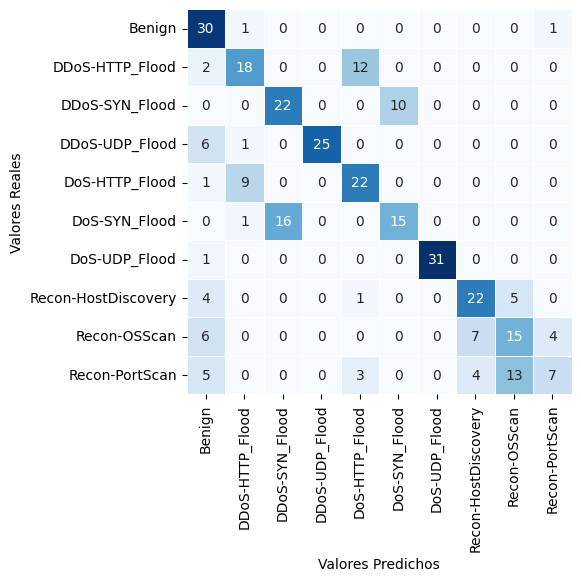

In [9]:
cm1 = confusion_matrix(y_test, y_pred)
normalized_matrix = cm1 #/ cm.sum(axis=1, keepdims=True)

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names,
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(5, 5)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

## Method 2: Precomputed Kernel

In [ ]:
import time

start = time.time()
matrix_train = qk.evaluate(x_vec=X_train)
stop = time.time()

train_time = stop - start

start = time.time()
matrix_test = qk.evaluate(x_vec=X_test, y_vec=y_test)
stop = time.time()

test_time = stop - start

KeyboardInterrupt: 

In [ ]:
from sklearn.svm import SVC

SVM = SVC(kernel="precomputed")

SVM.fit(matrix_train, y_train)
train_score = SVM.score(matrix_train, y_train)
test_score = SVM.score(matrix_test, y_test)

print(f"Training Time: {train_time}")
print(f"Testing Time: {test_time}")
print(f"Total Time: {train_time + test_time}")
print(f"Precomputed kernel classification training score: {train_score}")
print(f"Precomputed kernel classification test score: {test_score}")